In [1]:
import os
os.chdir("/content/drive/Shareddrives/yujung kim/Study/Python/time_series")

In [23]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta, time

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
with open('data/pv_forecast.pickle', 'rb') as f:
    pv = pickle.load(f)

# scaling

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
power_scaler = MinMaxScaler()
power_scaler.fit(pv[['power']])
pv['power_scale'] = power_scaler.transform(pv[['power']])

In [6]:
x_scaler = MinMaxScaler()
x_scaler.fit(pv[['dwpt', 'rhum', 'wspd', 'pres']])
pv[['dwpt', 'rhum', 'wspd', 'pres']] = x_scaler.transform(pv[['dwpt', 'rhum', 'wspd', 'pres']])

In [7]:
pv = pv.set_index('datetime')

In [8]:
tz = timezone(timedelta(hours=-6))
pv_train = pv.loc[:datetime(2006,12,21,23,tzinfo=tz)]
pv_test = pv.loc[datetime(2006,12,15,00,tzinfo=tz):datetime(2006,12,30,23,tzinfo=tz)]

# data loader

- torch 에서 LSTM 의 경우 
  - input: (seq_len, batch, input_size)
  - output: (seq_len, batch, num_directions * hidden_size) 

In [9]:
from torch.utils.data import DataLoader, Dataset

In [10]:
class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, num_feature, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        # seq_len
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output : shape = (window 크기, sample 개수)
        X = np.zeros([input_window, num_samples, num_feature])
        Y_src = np.zeros([output_window, num_samples, num_feature])
        Y_tgt = np.zeros([output_window, num_samples, num_feature])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i,:] = y[start_x:end_x]

            start_y = stride*i + input_window 
            end_y = start_y + output_window 
            Y_src[:,i] = y[(start_y-1):(end_y-1)]
            Y_tgt[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], num_feature).transpose((1,0,2)) # (seq_len, input_window, feature)
        Y_src = Y_src.reshape(Y_src.shape[0], Y_src.shape[1], num_feature).transpose((1,0,2)) # (seq_len, output_window, feature)
        Y_tgt = Y_tgt.reshape(Y_tgt.shape[0], Y_tgt.shape[1], num_feature).transpose((1,0,2))
        self.x = X[:,:-1,:]
        self.y_src = Y_src
        self.y_tgt = Y_tgt
        self.len = len(X)

    def __getitem__(self, i):
        return self.x[i], self.y_src[i], self.y_tgt[i]

    def __len__(self):
        return self.len

In [11]:
iw = 24*7
ow = 24
num_feature = 5

train_dataset = windowDataset(pv_train[['power_scale', 'rhum', 'dwpt', 'wspd', 'pres']], input_window=iw, output_window=ow, num_feature=num_feature, stride=24)
test_dataset = windowDataset(pv_test[['power_scale', 'rhum', 'dwpt', 'wspd', 'pres']], input_window=iw, output_window=ow, num_feature=num_feature, stride=24)

train_loader = DataLoader(train_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=4)

In [12]:
len(train_loader)

22

In [13]:
len(test_loader)

3

# transformer

- 시계열 데이터 transformer 적용이 목표이기 때문에 최대한 간단한 구조로 적용

- positional embedding 적용 x

- encoder, decoder 모두 1개의 layer

- target seq의 경우 teacher force prop 1/0 두가지로 적용

In [14]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
import torch.optim as optim

from tqdm.auto import tqdm
from typing import Optional, Tuple

In [38]:
"""
multihead attention layer 에서 attention energy 값 저장하도록 class 수정
need_weights=True 로 설정
"""

def attn_forward(self, query: Tensor, key: Tensor, value: Tensor, key_padding_mask: Optional[Tensor] = None,
            need_weights: bool = True, attn_mask: Optional[torch.Tensor] = None,
            average_attn_weights: bool = True) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
    is_batched = query.dim() == 3
    if self.batch_first and is_batched:
        query, key, value = [x.transpose(1, 0) for x in (query, key, value)]

    if not self._qkv_same_embed_dim:
        attn_output, attn_output_weights = F.multi_head_attention_forward(
            query, key, value, self.embed_dim, self.num_heads,
            self.in_proj_weight, self.in_proj_bias,
            self.bias_k, self.bias_v, self.add_zero_attn,
            self.dropout, self.out_proj.weight, self.out_proj.bias,
            training=self.training,
            key_padding_mask=key_padding_mask, need_weights=True,
            attn_mask=attn_mask, use_separate_proj_weight=True,
            q_proj_weight=self.q_proj_weight, k_proj_weight=self.k_proj_weight,
            v_proj_weight=self.v_proj_weight, average_attn_weights=average_attn_weights)
    else:
        attn_output, attn_output_weights = F.multi_head_attention_forward(
            query, key, value, self.embed_dim, self.num_heads,
            self.in_proj_weight, self.in_proj_bias,
            self.bias_k, self.bias_v, self.add_zero_attn,
            self.dropout, self.out_proj.weight, self.out_proj.bias,
            training=self.training,
            key_padding_mask=key_padding_mask, need_weights=True,
            attn_mask=attn_mask, average_attn_weights=average_attn_weights)
    
    self.attn = attn_output_weights
    if self.batch_first and is_batched:
        return attn_output.transpose(1, 0), attn_output_weights
    else:
        return attn_output, attn_output_weights

# teacher forcing = 1

In [84]:
def train(train_loader, tgt_mask, epochs=10):
    model.train()

    pbar = tqdm(range(epochs))
    for epoch in pbar:
        total_loss = 0.0
        attention_list = []

        for x, y_in, y_out in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y_in = y_in.to(device).float()
            y_out = y_out.to(device).float()
            output = model(x, y_in, tgt_mask=tgt_mask).to(device)
            attention_list.append(list(model.decoder.layers[0].multihead_attn.attn.detach().cpu().numpy()))
            # print(output.shape)
            loss = criterion(output[:,:,0], y_out[:,:,0])
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        pbar.set_postfix(loss=f"{(total_loss/len(train_loader)):.5f}")

    return np.array(sum(attention_list,[]))

In [99]:
def predict(test_loader, tgt_mask, file_name=None):
    model.eval()

    total_loss = 0.0
    outputs = []
    ys = []
    attention_list = []
    for t, (x, y_in, y_out) in enumerate(test_loader):
        # print(t)
        x = x.to(device).float()
        y_in = y_in.to(device).float()
        y_out = y_out.to(device).float()
        output = model(x, y_in, tgt_mask=tgt_mask).to(device)
        # print(output.shape)
        # outputs[t,:,:,:] = output
        attention_list.append(list(model.decoder.layers[0].multihead_attn.attn.detach().cpu().numpy()))
        outputs.append(list(output.detach().cpu().numpy()))
        ys.append(list(y_out.detach().cpu().numpy()))
        loss = criterion(output[:,:,0], y_out[:,:,0])
        total_loss += loss.cpu().item()

    print(f"test loss: {(total_loss/len(test_loader)):.5f}")

    return np.array(sum(outputs,[])), np.array(sum(ys,[])), np.array(sum(attention_list,[]))

In [86]:
device='cpu'
model = nn.Transformer(d_model=5, nhead=5, num_encoder_layers=1, num_decoder_layers=1, dim_feedforward=128, batch_first=True).to(device)

learning_rate=0.001
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [87]:
# multihead attention layer 에서 수정
model.decoder.layers[0].multihead_attn.__class__._forward = attn_forward
for layer in model.decoder.layers:
    layer.multihead_attn.forward = layer.multihead_attn._forward

In [88]:
target_mask = model.generate_square_subsequent_mask(24).to(device)
attention = train(train_loader, tgt_mask=target_mask, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [89]:
attention.shape

(348, 24, 167)

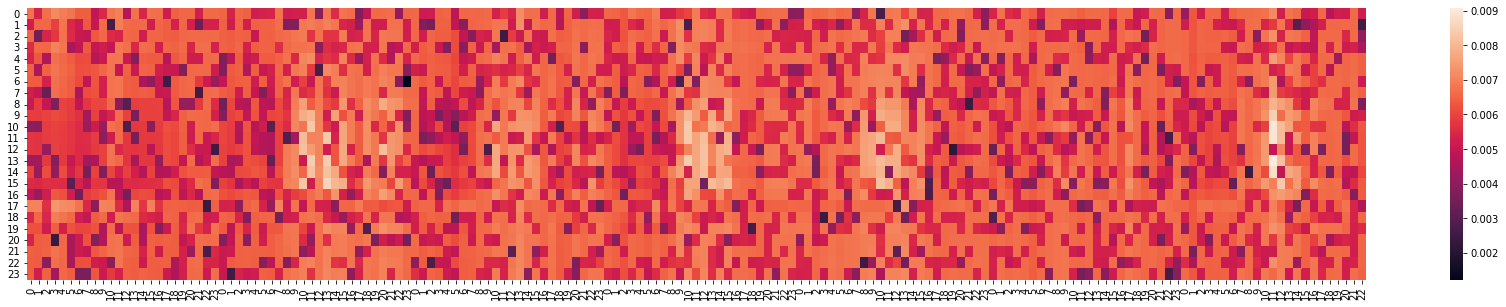

In [90]:
plt.figure(figsize=(30,5))
sns.heatmap(attention[0], xticklabels=[i%24 for i in range(167)])
plt.show()

In [100]:
pred, true, attention_test = predict(test_loader, tgt_mask=target_mask)

test loss: 0.02040


In [101]:
pred = power_scaler.inverse_transform(pred[:,:,0].reshape(-1,1))
true = power_scaler.inverse_transform(true[:,:,0].reshape(-1,1))

In [102]:
pred.shape

(216, 1)

In [103]:
pv_test = pv.loc[datetime(2006,12,22,00,tzinfo=tz):datetime(2006,12,30,23,tzinfo=tz)].copy()

In [104]:
pv_test.shape

(216, 19)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


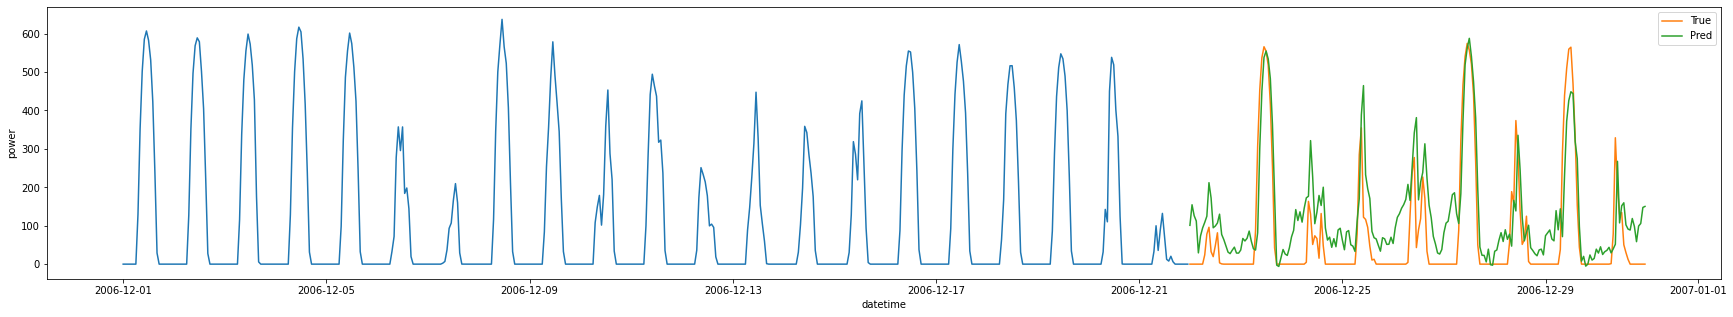

In [105]:
plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'])
sns.lineplot(pv_test.index, true.reshape(-1), label='True')
sns.lineplot(pv_test.index, pred.reshape(-1), label='Pred')
plt.legend()

In [107]:
attention_test.shape

(9, 24, 167)

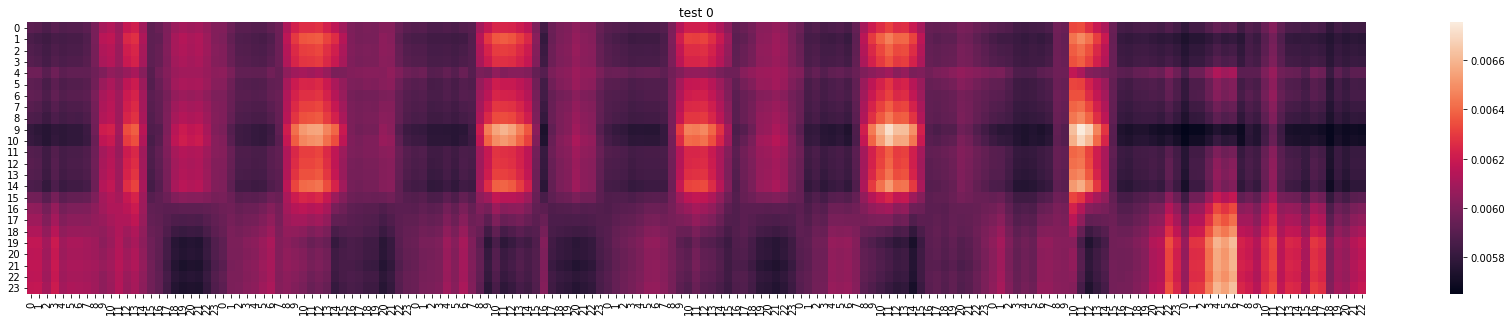

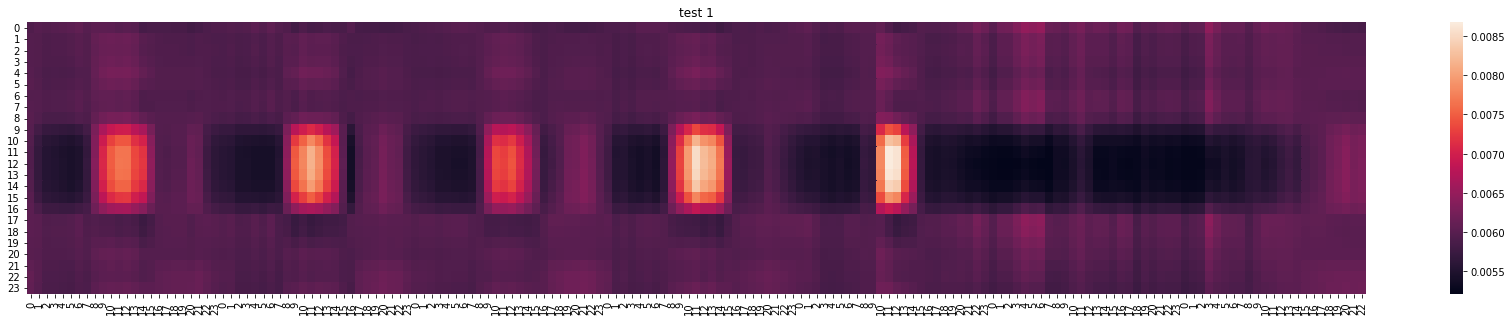

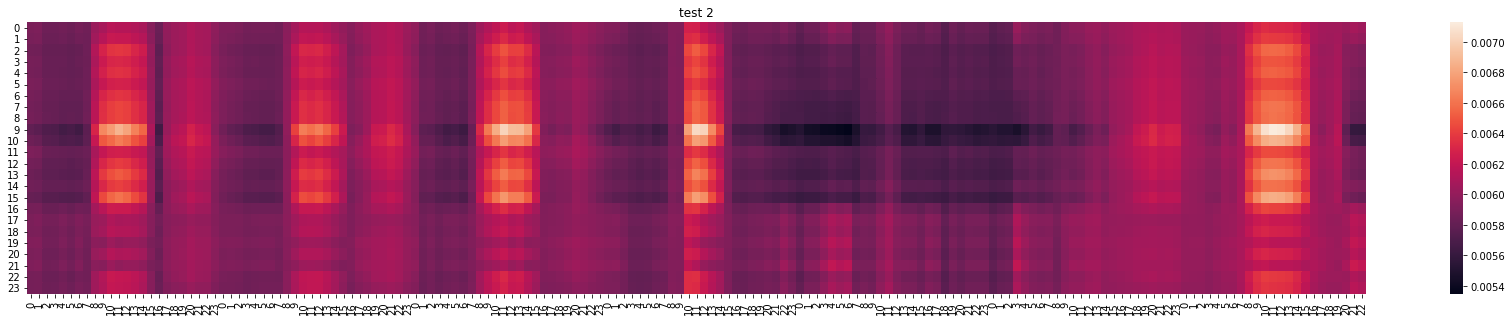

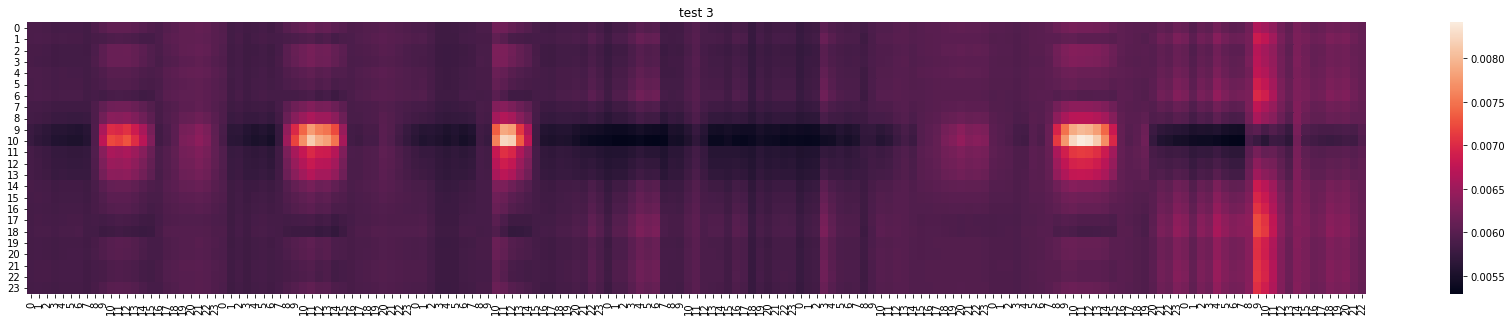

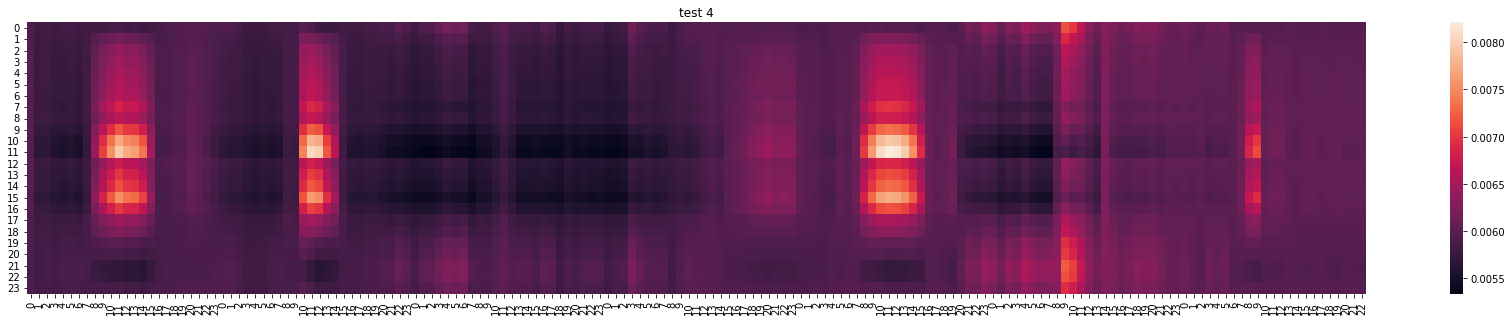

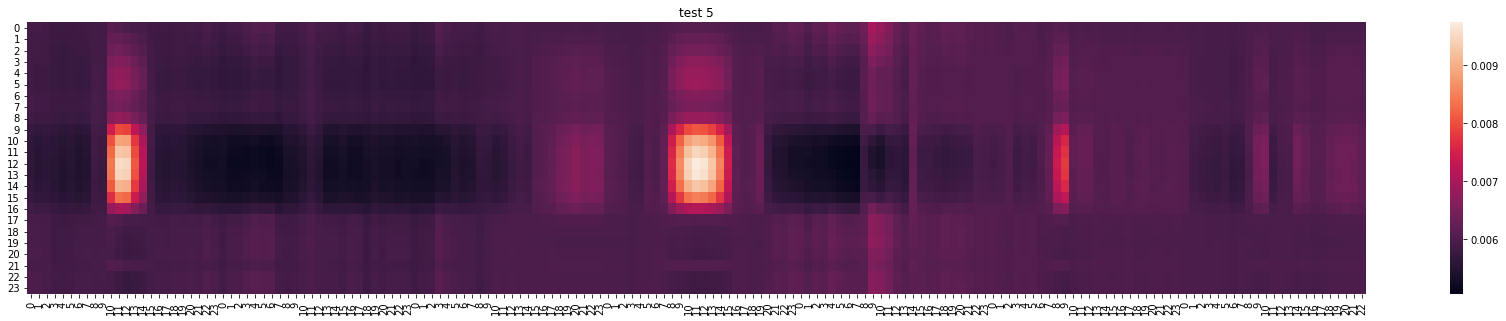

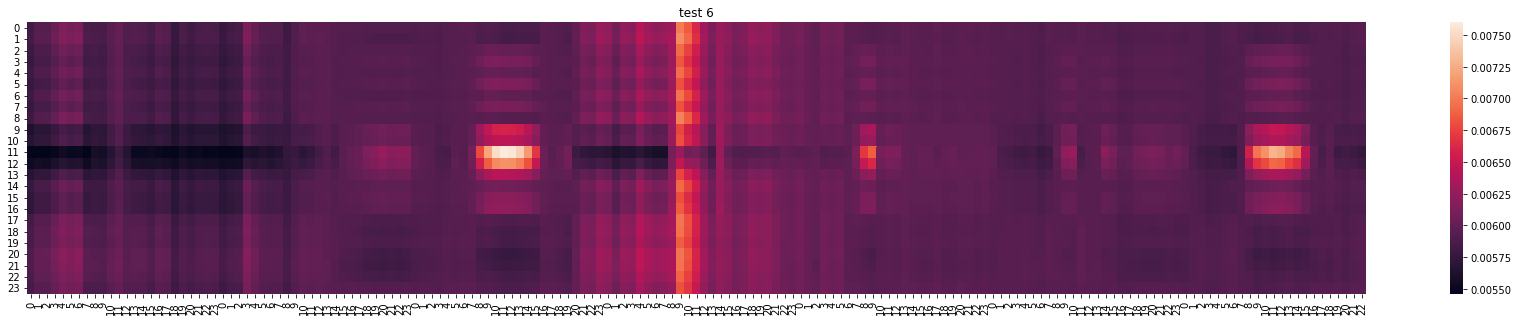

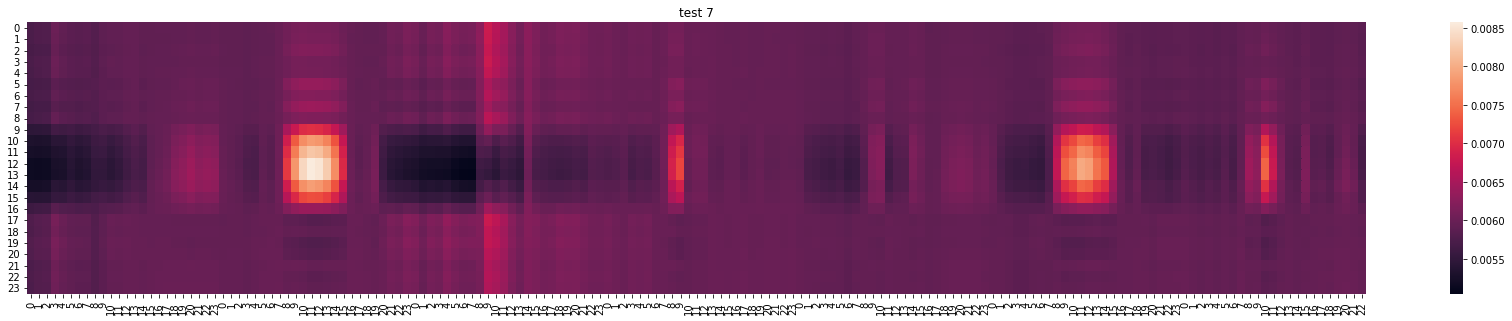

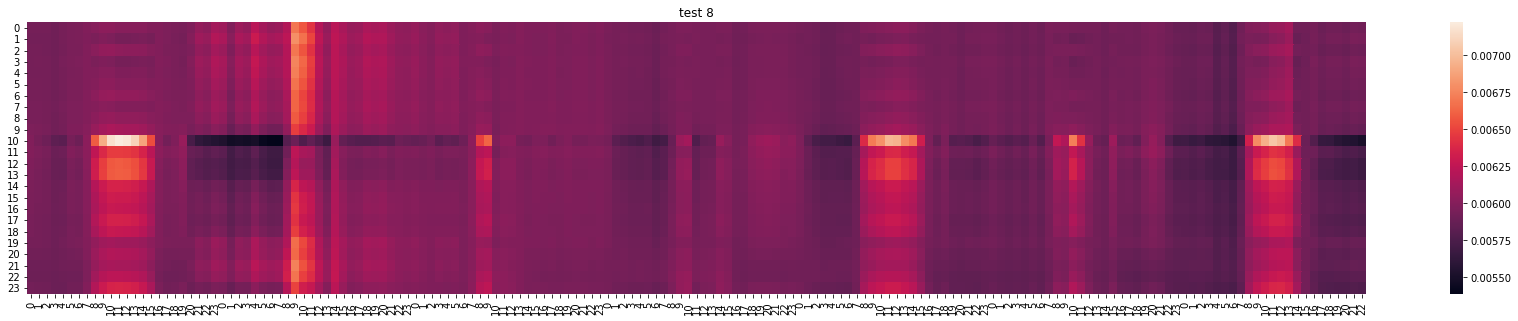

In [111]:
for i, attention in enumerate(attention_test):
    plt.figure(figsize=(30,5))
    sns.heatmap(attention, xticklabels=[i%24 for i in range(167)])
    plt.title(f"test {i}")
    plt.show()

# teacher forcing 0

In [ ]:
def train(train_loader, tgt_mask, max_len, epochs=10):
    model.train()

    pbar = tqdm(range(epochs))
    for epoch in pbar:
        total_loss = 0.0

        for x, y_in, y_out in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y_in = y_in.to(device).float()
            y_out = y_out.to(device).float()
            # print(y_in.shape)

            for t in range(max_len):
                y_in_temp = y_in[:,:(t+1),:]
                output = model(x, y_in_temp, tgt_mask=tgt_mask).to(device)
                if t < (max_len-1):
                    y_in[:,1:(t+2),:] = output[:,:(t+1),:]
            loss = criterion(output[:,:,0], y_out[:,:,0])
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        pbar.set_postfix(loss=f"{(total_loss/len(train_loader)):.5f}")

In [ ]:
def predict(test_loader, tgt_mask, max_len, file_name=None):
    model.eval()

    total_loss = 0.0
    outputs = []
    ys = []
    for t, (x, y_in, y_out) in enumerate(test_loader):
        # print(t)
        x = x.to(device).float()
        y_in = y_in.to(device).float()
        y_out = y_out.to(device).float()


        for t in range(max_len):
            y_in_temp = y_in[:,:(t+1),:]
            output = model(x, y_in_temp, tgt_mask=tgt_mask).to(device)
            if t < (max_len-1):
                y_in[:,1:(t+2),:] = output[:,:(t+1),:]
        outputs.append(list(output.detach().cpu().numpy()))
        ys.append(list(y_out.detach().cpu().numpy()))
        loss = criterion(output[:,:,0], y_out[:,:,0])
        total_loss += loss.cpu().item()

    print(f"test loss: {(total_loss/len(test_loader)):.5f}")

    return np.array(sum(outputs,[])), np.array(sum(ys,[]))

In [ ]:
device='cuda'
model = nn.Transformer(d_model=5, nhead=5, num_encoder_layers=1, num_decoder_layers=1, dim_feedforward=128, batch_first=True).to(device)

learning_rate=0.001
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [ ]:
target_mask = model.generate_square_subsequent_mask(24).to(device)
train(train_loader, tgt_mask=None, max_len=24, epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
pred, true = predict(test_loader, tgt_mask=None, max_len=24)

test loss: 0.03283


In [ ]:
pred = power_scaler.inverse_transform(pred[:,:,0].reshape(-1,1))
true = power_scaler.inverse_transform(true[:,:,0].reshape(-1,1))

In [ ]:
pv_test = pv.loc[datetime(2006,12,22,00,tzinfo=tz):datetime(2006,12,30,23,tzinfo=tz)].copy()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


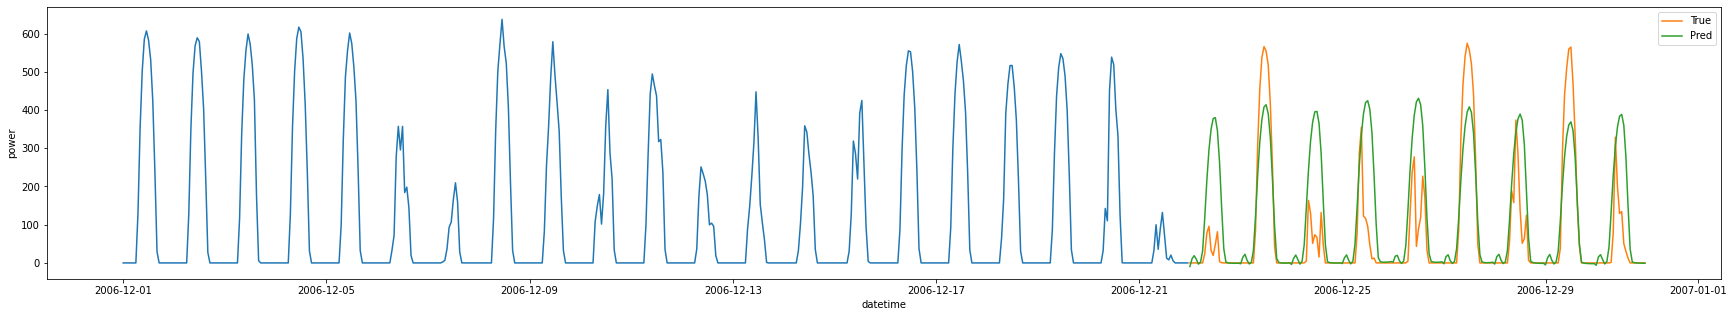

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'])
sns.lineplot(pv_test.index, true.reshape(-1), label='True')
sns.lineplot(pv_test.index, pred.reshape(-1), label='Pred')
plt.legend()